In [2]:
import requests
import datetime
import re

from bs4 import BeautifulSoup
from bs4 import NavigableString

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns
%matplotlib inline

In [30]:
one_city = 'Kazan'
another_city = 'Nizhniy'

one_city_flats = pd.read_csv('dags/avito/kazan_flats_2020-08-08.csv')
another_city_flats = pd.read_csv('dags/avito/flats_2020-07-17.csv')

# Clear and enrich

In [58]:
def remove_duplicates(flats):
    flats.drop_duplicates(subset ="href", keep = "first", inplace = True) 
def clear_apartment_type(flats):
    flats.apartment_type = flats.apartment_type.apply(lambda x: x.replace("\n ", ""))
def cast_postal_code(flats):
    flats.postal_code = flats.postal_code.astype('Int32')
def rename_floor_columns(flats):
    flats.rename(columns={'flat_floor':'apartment_floor'}, inplace=True)
def add_apartment_type_order_column(flats):
    flats['apartment_type_order'] = flats.apartment_type.map({'Студия': 0, '1-к квартира': 1, '2-к квартира': 2, '3-к квартира': 3, '4-к квартира': 4, '5-к квартира': 5})
def sort_by_apartment_type(flats):
    flats = flats.sort_values('apartment_type_order')
    
def _distance_convert(distance):    
    if distance is not np.nan:
        first_part = re.findall(r'\d+',distance)[0]
        if 'км' in distance:
            result = re.findall(r',\d+',distance)
            if len(result) != 0:
                result = result[0].replace(',','')
                first_part = int(float(first_part+result)*100)
            else:
                first_part = int(first_part)*1000
        return int(first_part)
    return distance
def compute_converted_distance(flats):
    flats['converted_distance'] = flats.metro_distance.apply(_distance_convert)


def _apartment_floor_to_group(apartment_floor, building_floor):
    if int(apartment_floor) < 2:
        return 'button'
    if int(building_floor) - int(apartment_floor) < 1:
        return 'up'
    return 'middle'
def compute_apartment_floor_group(flats):
    flats['apartment_floor_group'] = flats.apply(
        lambda row: _apartment_floor_to_group(row['apartment_floor'], row['building_floor']), 
        axis=1)

def _area_to_city_side(area):
    if area in ['Приокский район', 'Советский район', 'Нижегородский район']:
        return 'Нагорная часть'
    if area in ['Автозаводский район', 'Канавинский район', 'Ленинский район', 'Московский район', 'Сормовский район']:
        return 'Заречная часть'
    return 'область'
def compute_city_side(flats):
    flats['side'] = flats.area.apply(_area_to_city_side)
    

def _clear_countryside_area(area):
    if area in ['Приокский район', 'Советский район', 'Нижегородский район','Автозаводский район', 'Канавинский район', 'Ленинский район', 'Московский район', 'Сормовский район']:
        return area
    return 'область'
def clear_countryside_area(flats):
    flats['area'] = flats.area.apply(_clear_countryside_area)

def _building_floor_to_floor_group(floor):
    if int(floor) < 6:
        return 1
    if int(floor) < 12:
        return 2
    return 3
def compute_floor_group(flats):
    flats['floor_group'] = flats.building_floor.apply(_building_floor_to_floor_group)

In [61]:
one_city_flats['city'] = 'kazan'
another_city_flats['city'] = 'nizhniy'

for _flats in [one_city_flats, another_city_flats]:
    rename_floor_columns(_flats)
    remove_duplicates(_flats)
    clear_apartment_type(_flats)
    clear_countryside_area(_flats)
    cast_postal_code(_flats)
    add_apartment_type_order_column(_flats)
    sort_by_apartment_type(_flats)
    compute_converted_distance(_flats)
    compute_floor_group(_flats)

In [63]:
one_city_flats.head()

,href,apartment_type,price,address,square,building_floor,apartment_floor,commission_percent,time_of_creation,agency,...,metro_station,latitude,longitude,postal_code,area,city,apartment_type_order,converted_distance,apartment_floor_group,floor_group
0,/kazan/kvartiry/2-k_kvartira_45_m_55_et._19058...,2-к квартира,18000,"Вахитовский район, Большая Красная ул., 3",45.0,5,5,0,2020-07-30 10:09:00,NaN,...,Кремлёвская,55.799011,49.112406,420111,область,kazan,2,600.0,up,1
1,/kazan/kvartiry/2-k_kvartira_46_m_25_et._19651...,2-к квартира,12000,"Портовая ул., 17",46.0,5,2,50,2020-07-28 09:05:00,Агентство,...,Площадь Тукая,55.771525,49.096542,420108,область,kazan,2,2400.0,middle,1
2,/kazan/kvartiry/2-k_kvartira_50_m_35_et._19587...,2-к квартира,15000,"ул. Академика Кирпичникова, 17",50.0,5,3,0,2020-07-23 08:48:00,Агентство,...,без метро,55.810390,49.185385,420029,Советский район,kazan,2,NaN,middle,1
3,/kazan/kvartiry/1-k_kvartira_39_m_319_et._1951...,1-к квартира,15000,"ул. Родины, 24В",39.0,19,3,0,2020-07-27 13:12:00,Агентство,...,Горки,55.762662,49.193595,<NA>,Советский район,kazan,1,300.0,middle,3
4,/kazan/kvartiry/2-k_kvartira_45_m_316_et._1949...,2-к квартира,17000,"ул. Архитектора Гайнутдинова, 22",45.0,16,3,0,2020-08-01 12:06:00,NaN,...,без метро,55.804010,49.223249,420025,Советский район,kazan,2,NaN,middle,3


# Remove apartments with 5 rooms 
#### We have only one row with this type of apartment so we will remove this type from our dataset.

In [65]:
one_city_flats[one_city_flats.apartment_type == '5-к квартира']

,href,apartment_type,price,address,square,building_floor,apartment_floor,commission_percent,time_of_creation,agency,...,metro_station,latitude,longitude,postal_code,area,city,apartment_type_order,converted_distance,apartment_floor_group,floor_group
115,/kazan/kvartiry/5-k_kvartira_205.6_m_27_et._18...,5-к квартира,75000,"ул. Патриса Лумумбы, 44",205.6,7,2,0,2020-07-14 14:53:00,NaN,...,Суконная слобода,55.791405,49.178899,420081,Советский район,kazan,5,2800.0,middle,2
1251,/kazan/kvartiry/5-k_kvartira_146_m_46_et._1962...,5-к квартира,70000,"ул. Ульянова-Ленина, 19",146.0,6,4,50,2020-07-30 10:22:00,Агентство,...,Площадь Тукая,55.784324,49.132851,420012,область,kazan,5,700.0,middle,2
1570,/kazan/kvartiry/5-k_kvartira_156_m_47_et._1782...,5-к квартира,100000,"ул. Вишневского, 49Б",156.0,7,4,50,2020-07-13 11:13:00,LasVegas Агентство Элитной Недвижимости,...,Суконная слобода,55.784627,49.151617,420043,область,kazan,5,1000.0,middle,2
1967,/kazan/kvartiry/5-k_kvartira_213_m_410_et._599...,5-к квартира,35000,"ул. Кул Гали, 2",213.0,10,4,50,2020-08-03 11:34:00,Агентство,...,Проспект Победы,55.755642,49.222431,420141,Советский район,kazan,5,1100.0,middle,2
2045,/kazan/kvartiry/5-k_kvartira_160_m_1010_et._18...,5-к квартира,135000,"ул. Сибгата Хакима, 3",160.0,10,10,50,2020-07-13 09:58:00,Агентство,...,Козья Слобода,55.815054,49.106288,420066,область,kazan,5,600.0,up,2
2143,/kazan/kvartiry/5-k_kvartira_105_m_12_et._1964...,5-к квартира,23000,"Кожевенная ул., 14",105.0,2,1,0,2020-07-15 17:24:00,Агентство,...,Козья Слобода,55.803130,49.069969,420030,область,kazan,5,2400.0,button,1


In [66]:
one_city_flats = one_city_flats[one_city_flats.apartment_type != '5-к квартира']
another_city_flats = another_city_flats[another_city_flats.apartment_type != '5-к квартира']

# Visualize utils

In [67]:
def plot_pie_chart(flats, column, explode=None):
    plt.figure(figsize=(8,8))  
    flats[column].value_counts().plot.pie(explode=explode, autopct='%1.0f%%',shadow=False, startangle=90,  
                                                 pctdistance=0.5, labeldistance=1.2)
    
def plot_box_chart(flats, column, map_values = None):
    flats.boxplot(column=['price'], by=column,patch_artist=True, figsize=(12, 8))
    if map_values is not None:
        plt.xticks(map_values[0], map_values[1])
    
def plot_linear_chart(flats, column, column_values=None, labels=None):
    plt.figure(figsize=(12,7))  
    if labels is None:
        labels = column_values
    sns.set_style("white")
    
    if column_values is None:
        sns.distplot(flats[column], bins=30)
    else:
        for column_value, label in zip(column_values, labels):
            x1 = flats.loc[flats[column]==column_value].price
            sns.distplot(x1, label=label)
    plt.legend()
    
def boxplot_sorted(df, by, column, rot=45):  
    df2 = pd.DataFrame({col:vals[column] for col, vals in df.groupby(by)})
    meds = df2.median().sort_values()
    df2[meds.index].boxplot(rot=rot, return_type="axes", figsize=(12,8))

# Data utils

In [68]:
def bound_flats_py_price(flats, low=5_000, high=45_000):
    return flats[(flats['price']>low) & (flats['price']<high)]

---
---
---
# Our statisitcs will have 3 point:
1) Basic statisitcs for flats dates by Jule 2020

2) We will give assumptions to price dependence feature

3) We will to compare 2019 flats with 2020 flats prices 

---
---
---
# Basic statistics on August 2020

# Number of apartments by percentage

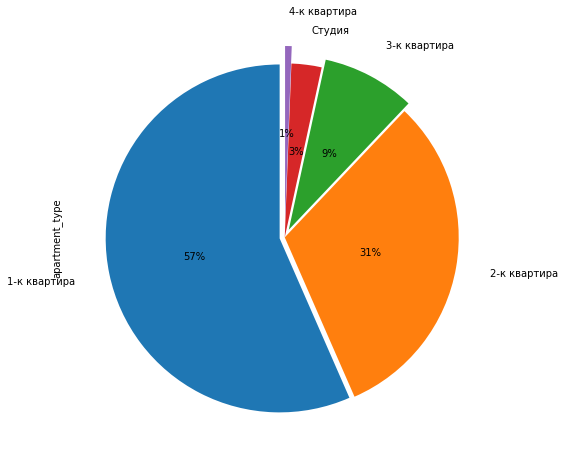

In [69]:
plot_pie_chart(one_city_flats, 'apartment_type', explode=[0.03,0.00,0.05, 0.00, 0.1])

# Common price distribution

<Figure size 720x576 with 0 Axes>

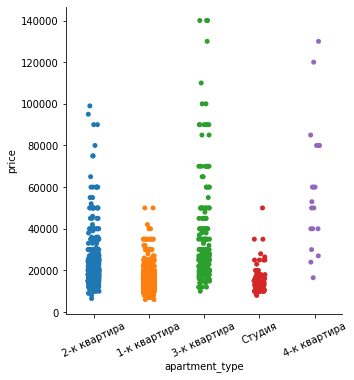

In [70]:
plt.figure(figsize=(10,8))
sns.catplot(x="apartment_type", y="price", data=one_city_flats);
plt.xticks(rotation=25) 
plt.ioff()

No handles with labels found to put in legend.


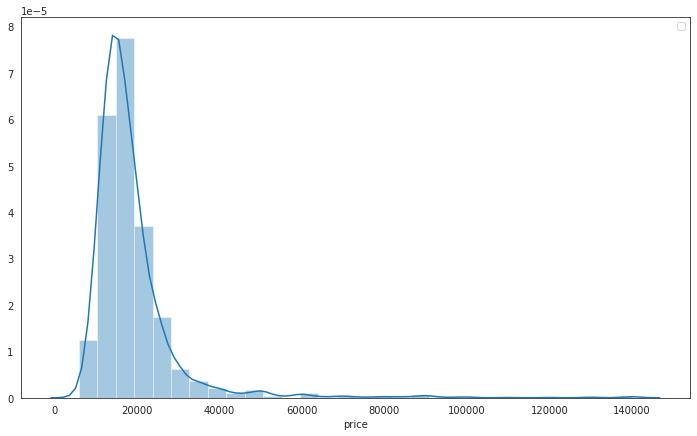

In [71]:
plot_linear_chart(one_city_flats, 'price')

No handles with labels found to put in legend.


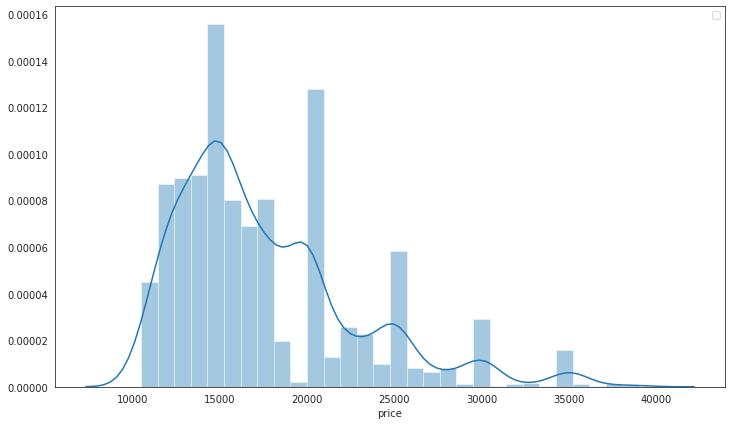

In [72]:
bounded_price_flats = one_city_flats[(one_city_flats.price > 10_000) & (one_city_flats.price < 40_000)]

plot_linear_chart(bounded_price_flats, 'price')

# Basic statistics by `area`

/home/daniil/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


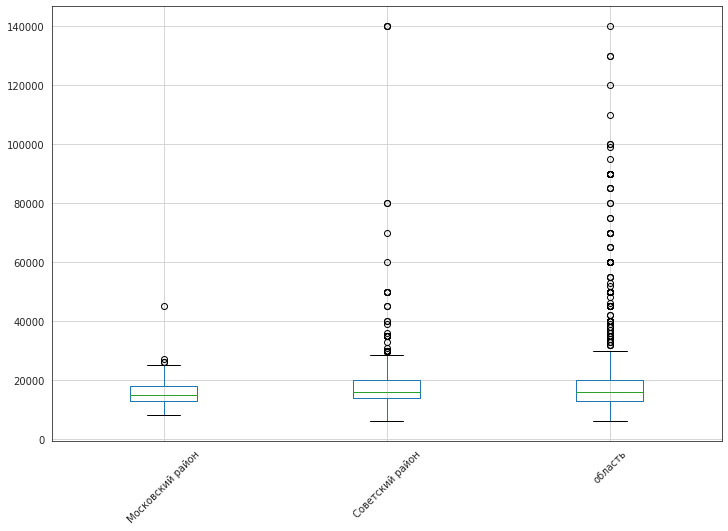

In [73]:
boxplot_sorted(one_city_flats, 'area', 'price', 45)

<Figure size 1152x1152 with 0 Axes>

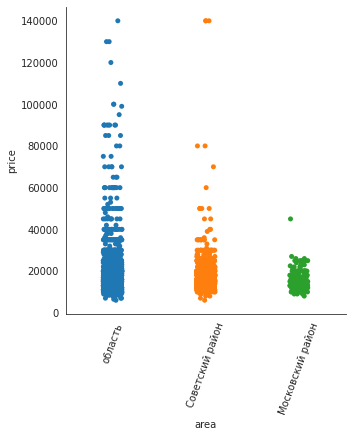

In [74]:
plt.figure(figsize=(16,16))
sns.catplot(x="area", y="price", data=one_city_flats);
plt.xticks(rotation=70)
plt.ioff()

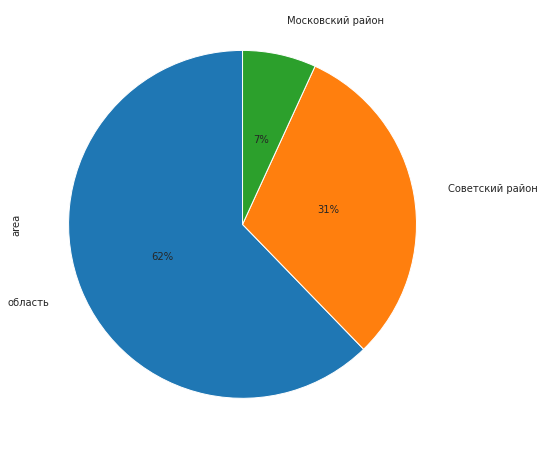

In [75]:
plot_pie_chart(one_city_flats, 'area')

# Basic statistics by `floor`

#### We can see more dominance of buildings with 5 and 9 floor. We can assume that old building and following what  more than half of bulding is old

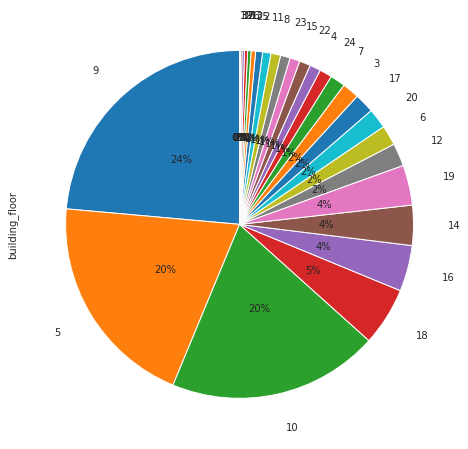

In [76]:
plot_pie_chart(one_city_flats, 'building_floor')

### We was split buildings by 3 floor groups with assamption what price in building with low than 5 floors less then in building with higher than 12 floors

#### And we confirmed it

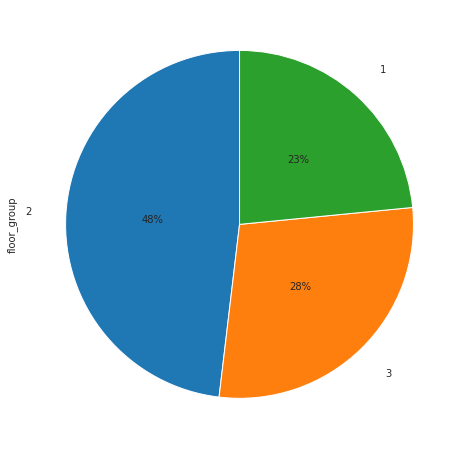

In [78]:
plot_pie_chart(one_city_flats, 'floor_group')

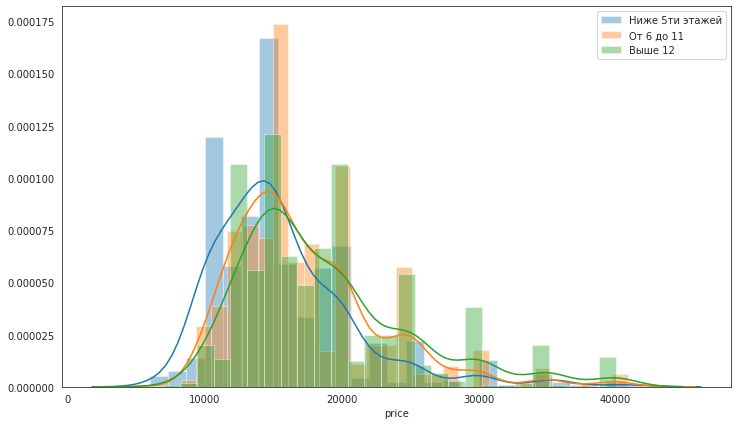

In [79]:
bounded_floor_group = one_city_flats[(one_city_flats.price > 5_000) & (one_city_flats.price < 45_000)]

plot_linear_chart(bounded_floor_group, 'floor_group', [1,2,3], ["Ниже 5ти этажей", "От 6 до 11", "Выше 12"])

## Apartment floor

### We was split buildings by 3 apartment floor groups with assamption what price in apartment on lowest building floor less than in apartment on highest building floor

#### Its quiet similar so we cannot confirm it.

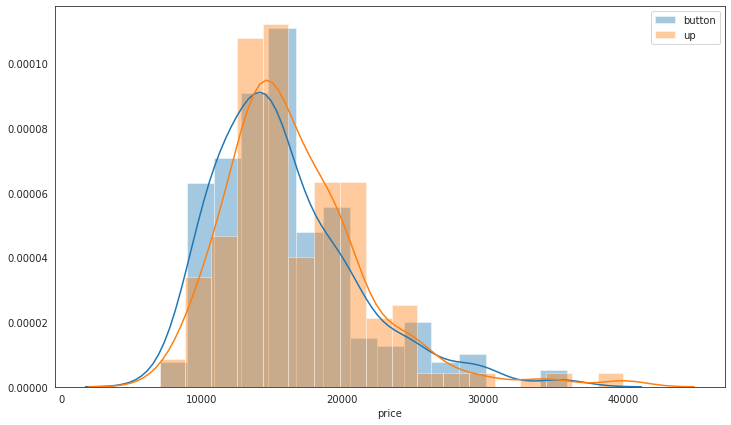

In [80]:
plot_linear_chart(bounded_floor_group, 'apartment_floor_group', ['button', 'up'])

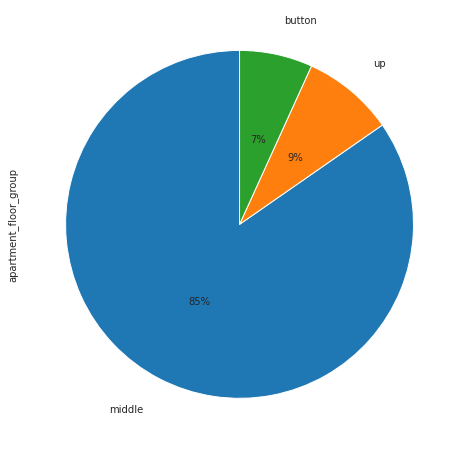

In [81]:
plot_pie_chart(bounded_floor_group, 'apartment_floor_group')

# Basic statistics by `lat` and `long`

In [83]:
import folium
from folium.plugins import HeatMap
m=folium.Map([56.301365, 43.984700],zoom_start=11)
HeatMap(one_city_flats[['latitude','longitude']].dropna(),radius=8,gradient={0.2:'blue',0.4:'purple',0.6:'orange',1.0:'red'}).add_to(m)
display(m)

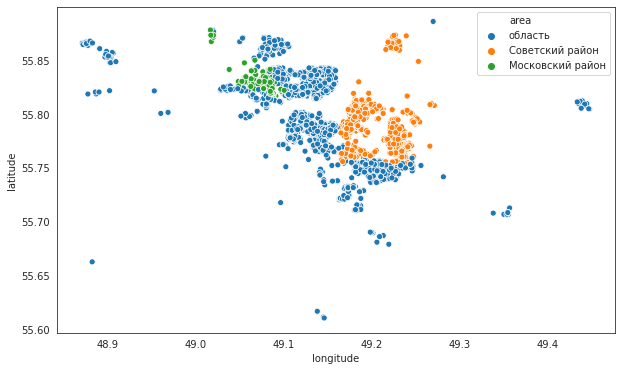

In [88]:
flats = one_city_flats[one_city_flats.longitude < 55]

plt.figure(figsize=(10,6))
sns.scatterplot(flats.longitude,flats.latitude,hue=flats.area)
plt.ioff()

(array([48.8, 48.9, 49. , 49.1, 49.2, 49.3, 49.4, 49.5]),
 <a list of 8 Text major ticklabel objects>)

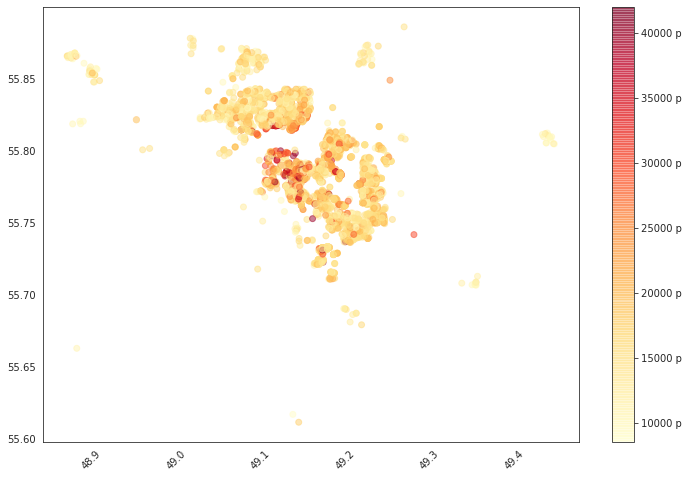

In [89]:
bound_flats_for_lat_and_long = bound_flats_py_price(flats, low=8_000)

plt.figure(figsize=(12,8))  
sctr = plt.scatter(bound_flats_for_lat_and_long['longitude'], 
            bound_flats_for_lat_and_long['latitude'], 
            c=bound_flats_for_lat_and_long['price'],
            cmap='YlOrRd',
            alpha=0.5)
plt.colorbar(sctr,format='%d р')
plt.xticks(rotation=45)

# Compare Kazan with Nizhniy Novgorod
---

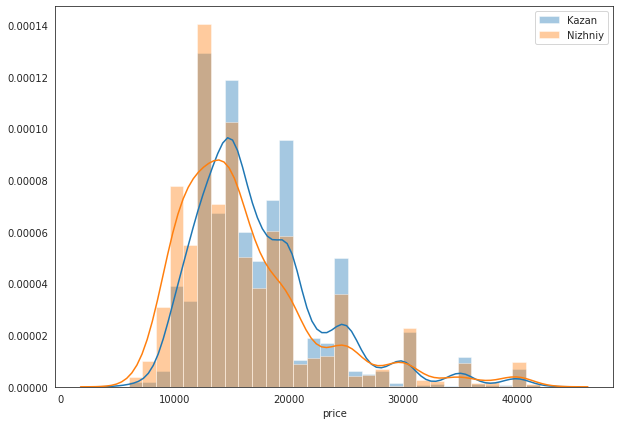

In [90]:
bounded_flats = bound_flats_py_price(one_city_flats)
bounded_another_flats = bound_flats_py_price(another_city_flats)

plt.figure(figsize=(10,7)) 
sns.set_style("white")
sns.distplot(bounded_flats['price'], bins=30, label=one_city)
sns.distplot(bounded_another_flats['price'], bins=30, label=another_city)
plt.legend()

In [91]:
concat_flats = bounded_flats.append(bounded_another_flats, ignore_index=True, sort=False)

/home/daniil/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


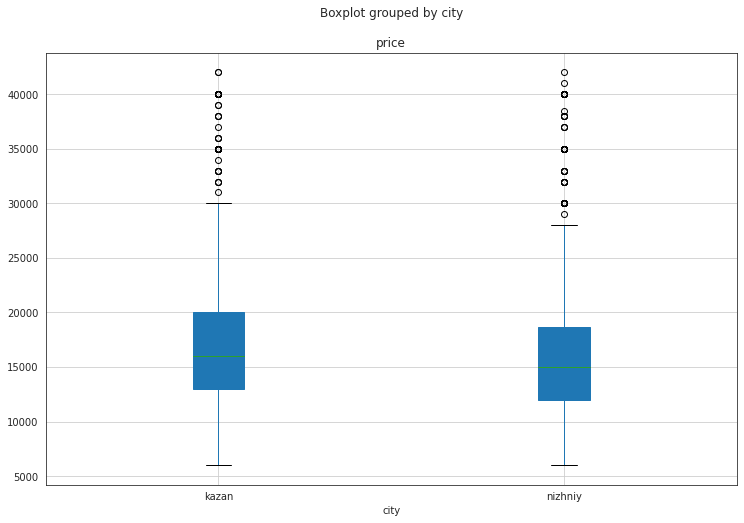

In [92]:
plot_box_chart(concat_flats, 'city')

In [99]:
print(one_city, ': ', bounded_flats.mean().price, 'vs ',another_city ,
      ': ', bounded_another_flats.mean().price)

Kazan :  17353.94074809666 vs  Nizhniy :  16238.444871091608


In [101]:
print(one_city, ': ', one_city_flats.mean().price, 'vs ',another_city ,': ', another_city_flats.mean().price)

Kazan :  18862.56183745583 vs  Nizhniy :  17410.20478723404


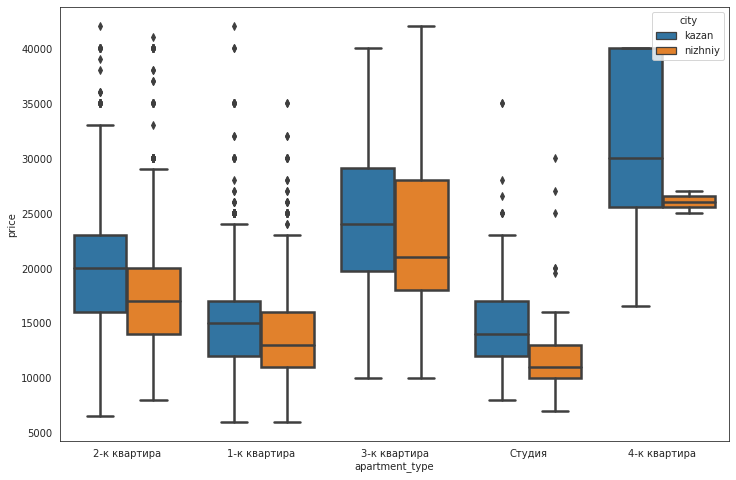

In [103]:
plt.figure(figsize=(12,8)) 
sns.boxplot(x="apartment_type", y="price", hue="city",
                 data=concat_flats, linewidth=2.5)